In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import yahist

In [3]:
yahist.utils.set_default_style()

In [10]:
df_byreport = pd.read_json("../sources/cdc/data/data_byreport.json.gz")
df_byonset = pd.read_json("../sources/cdc/data/data_byonset.json.gz")

In [12]:
df_byreport.groupby("fetched")["date"].max()

fetched
20200324185621   2020-03-23
20200325215200   2020-03-24
20200326222115   2020-03-25
20200328002535   2020-03-26
20200329012306   2020-03-27
20200330015331   2020-03-28
20200331035945   2020-03-29
20200401081227   2020-03-30
20200402092218   2020-03-31
20200403172943   2020-04-02
20200404193704   2020-04-03
20200405194001   2020-04-04
20200406191522   2020-04-05
20200407201636   2020-04-06
Name: date, dtype: datetime64[ns]

In [13]:
df_byonset.groupby("fetched")["date"].max()

fetched
20200306205315   2020-03-05
20200310004104   2020-03-08
20200311010830   2020-03-09
20200312030803   2020-03-10
20200313040835   2020-03-11
20200314081802   2020-03-12
20200317130046   2020-03-15
20200318171829   2020-03-18
20200319175255   2020-03-18
20200320175410   2020-03-19
20200324153906   2020-03-20
20200324185621   2020-03-23
20200325215201   2020-03-24
20200326222115   2020-03-25
20200328002536   2020-03-26
20200331035946   2020-03-29
20200401081228   2020-03-30
20200402092219   2020-03-31
20200403172942   2020-04-02
20200406231451   2020-04-06
20200407233815   2020-04-06
Name: date, dtype: datetime64[ns]

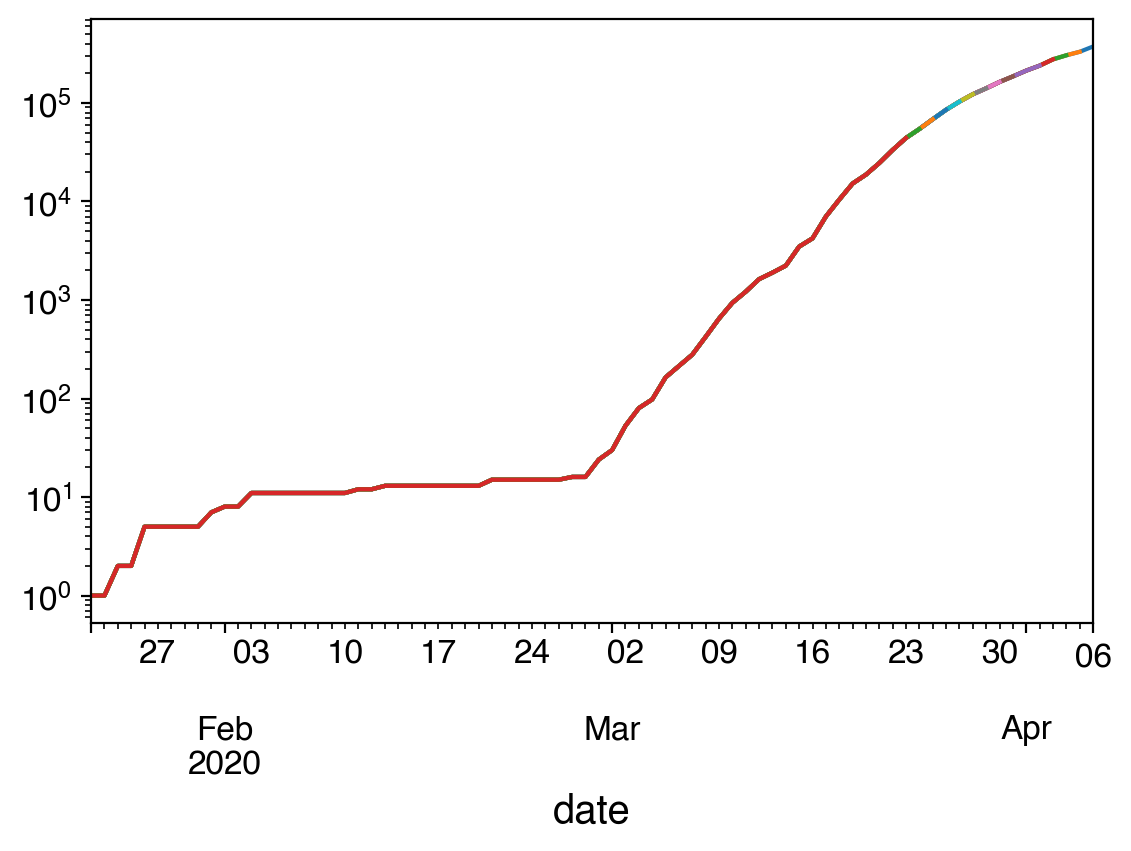

In [28]:
df_byreport.set_index("date").sort_index(ascending=False).groupby("fetched", sort=False)["cases"].plot(logy=True);

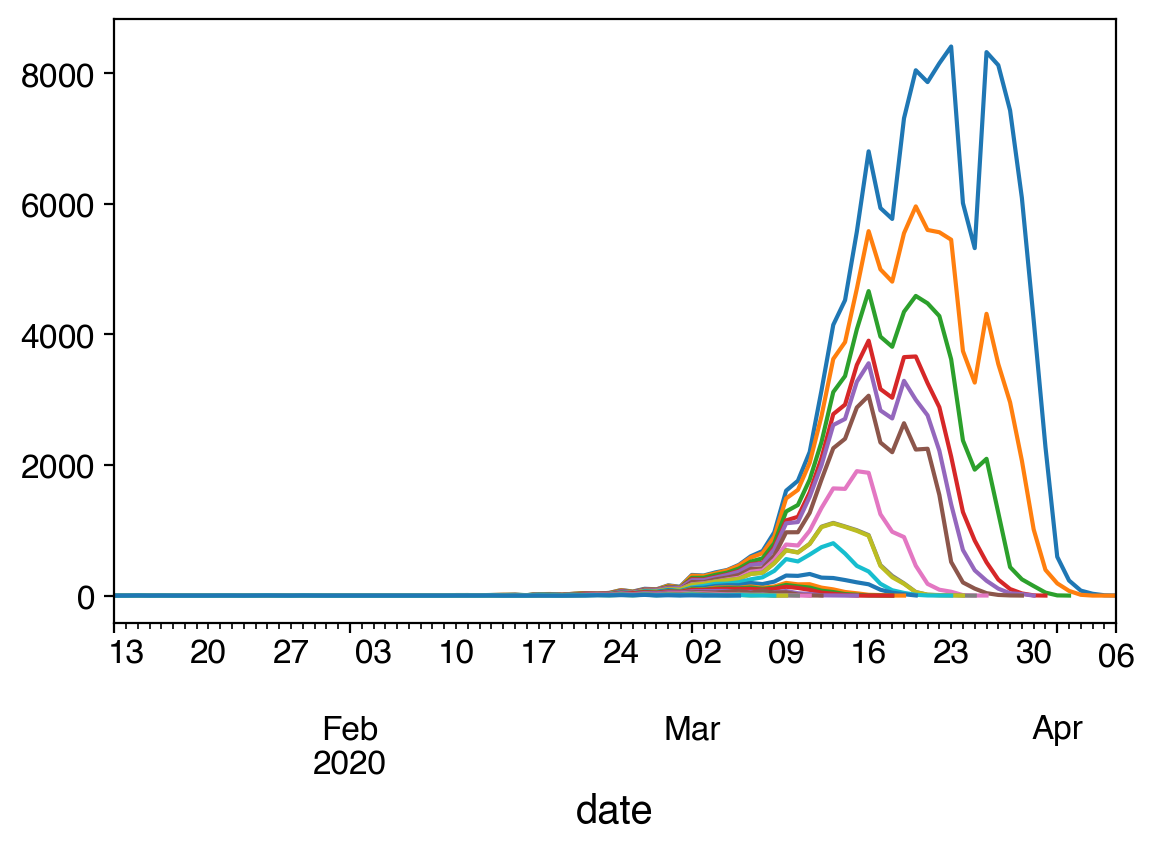

In [30]:
# fig, ax = plt.subplots()
df_byonset.set_index("date").sort_index(ascending=False).groupby("fetched", sort=False)["cases"].plot(logy=False);
# ax.legend()

In [88]:
fs = df_byonset["fetched"].value_counts().sort_index().index
df_newcases = []
for f1,f2 in zip(fs[:-1],fs[1:]):
    df1 = df_byonset[df_byonset["fetched"] == f1]
    df2 = df_byonset[df_byonset["fetched"] == f2]
    newcases = (df2.set_index("date")["cases"] - df1.set_index("date")["cases"]).clip(0).fillna(0.)
    df = pd.DataFrame()
    df["newcases"] = newcases
    df["frac"] = newcases/newcases.sum()
    df["left"] = f1 # left edge fetched date
    df["right"] = f2 # right edge fetched date
    df_newcases.append(df)
df_newcases = pd.concat(df_newcases, sort=True)
df_newcases["right"] = pd.to_datetime(df_newcases["right"].astype(str)).dt.strftime("%Y-%m-%d %-I%p")
df_newcases

,frac,left,newcases,right
date,,,,
2020-01-12,0.000000,20200306205315,0.0,2020-03-10 12AM
2020-01-13,0.000000,20200306205315,0.0,2020-03-10 12AM
2020-01-14,0.000000,20200306205315,0.0,2020-03-10 12AM
2020-01-15,0.000000,20200306205315,0.0,2020-03-10 12AM
2020-01-16,0.000000,20200306205315,0.0,2020-03-10 12AM
...,...,...,...,...
2020-04-02,0.003535,20200406231451,159.0,2020-04-07 11PM
2020-04-03,0.001423,20200406231451,64.0,2020-04-07 11PM
2020-04-04,0.000623,20200406231451,28.0,2020-04-07 11PM


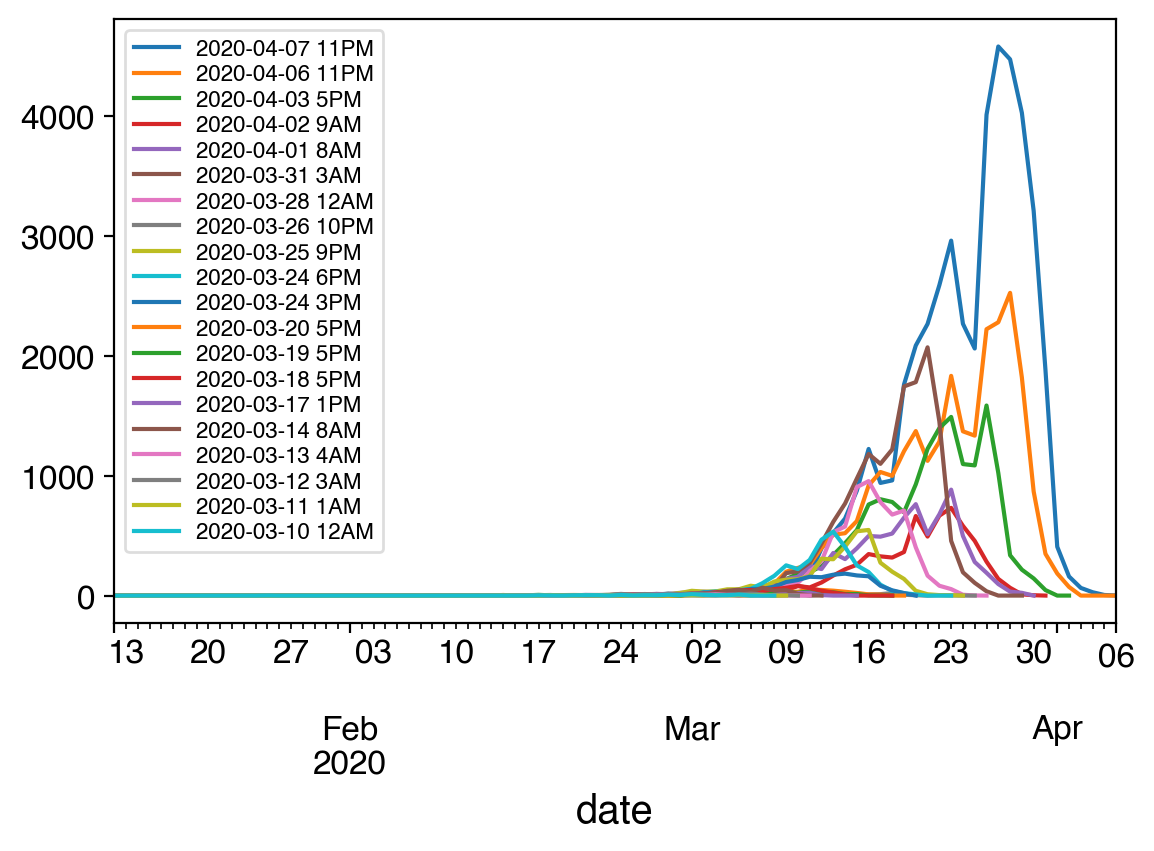

In [89]:
fig, ax = plt.subplots()
df_newcases.sort_index(ascending=False).groupby("right", sort=False)["newcases"].plot();
ax.legend(loc="upper left", fontsize=8)

In [145]:
data = []
for name,group in df_newcases.sort_index(ascending=False).groupby("right", sort=False):
#     print(name)
#     print(df)

    # by weighted mean
    weighted_dayofyear = ((group.index.dayofyear.values * group["newcases"].values)/group["newcases"].values.sum()).sum()
    # by peak new cases
    peak_dayofyear = group[group["newcases"] == group["newcases"].max()].index.dayofyear[0]
#     print(name)
#     print(group["newcases"].max())
#     break
#     interval_dayofyear = 0.5*(pd.Timestamp(name).dayofyear + group[]
    leftedge_dayofyear = (pd.Timestamp(str(group["left"].values[0]))).dayofyear
    rightedge_dayofyear = (pd.Timestamp(str(group["right"].values[0]))).dayofyear
    center_dayofyear = 0.5*(leftedge_dayofyear + rightedge_dayofyear)
    data.append(dict(
        date=pd.Timestamp(str(group["right"].values[0])),
        mean_diff=center_dayofyear-weighted_dayofyear,
        peak_diff=center_dayofyear-peak_dayofyear,
    ))
df = pd.DataFrame(data).set_index("date")
df

,mean_diff,peak_diff
date,,
2020-04-07 23:00:00,13.251501,10.5
2020-04-06 23:00:00,13.015481,7.5
2020-04-03 17:00:00,12.735422,7.5
2020-04-02 09:00:00,12.513059,9.5
2020-04-01 08:00:00,13.472704,8.5
2020-03-31 03:00:00,11.770211,8.5
2020-03-28 00:00:00,11.197280,11.0
2020-03-26 22:00:00,11.000000,7.5
2020-03-25 21:00:00,11.431927,8.5


(0, 14.0)

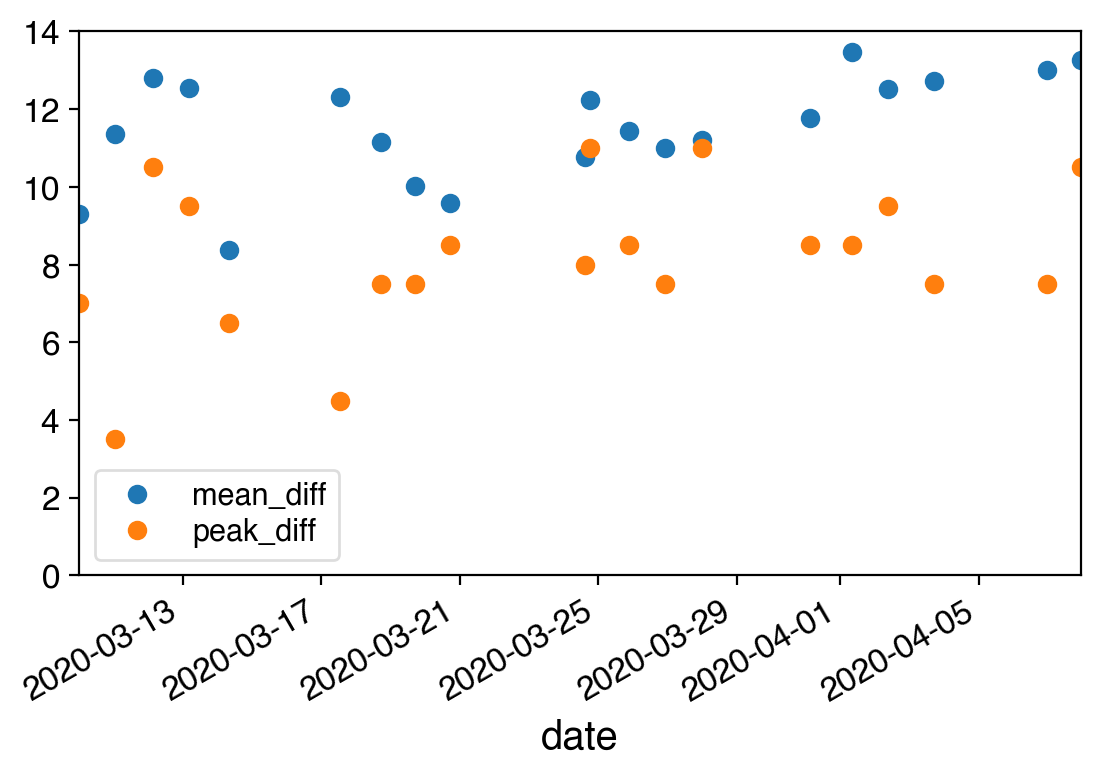

In [151]:
fig, ax = plt.subplots()
df.plot(ax=ax,marker="o",lw=0)
ax.set_ylim([0,round(df.values.max()+1,0)])